## Regularized Maximum Likelihood (RML) Method for Black Hole Imaging

### Import libraries and modules

In [1]:
import cv2
from numpy.random import randint
import random
import ehtim.const_def as ehc
import ehtim.observing.obs_helpers as obsh
from ehtim.observing.obs_helpers import *

# Import proximal gradient descent
from regularized_maximum_likelihood import *
# Import dataset
from keras.datasets import mnist
# Import eht imaging package
import ehtim as eh 

Welcome to eht-imaging! v  1.1.1


Using TensorFlow backend.


### Define Imaging Variables

In [2]:
'''Define observation parameters.'''
eht_array='EHT2019'
target='sgrA'

nsamp = 10000
npix = 32 
fov_param = 100.0
flux_label = 1
sefd_param = 1

tint_sec = 5    # integration time in seconds
tadv_sec = 600  # advance time between scans
tstart_hr = 0   # GMST time of the start of the observation
tstop_hr = 24   # GMST time of the end
bw_hz = 4e9     # bandwidth in Hz

stabilize_scan_phase = False # if true then add a single phase error for each scan to act similar to adhoc phasing
stabilize_scan_amp = False # if true then add a single gain error at each scan
jones = False # apply jones matrix for including noise in the measurements (including leakage)
inv_jones = False # no not invert the jones matrix
frcal = True # True if you do not include effects of field rotation
dcal = True # True if you do not include the effects of leakage
dterm_offset = 0 # a random offset of the D terms is given at each site with this standard deviation away from 1
dtermp = 0

array = 'arrays/' + eht_array + '.txt'
eht = eh.array.load_txt(array)

# Define observation field of view
fov = fov_param * eh.RADPERUAS

# define scientific target
if target == 'm87':
    ra = 12.513728717168174
    dec = 12.39112323919932
elif target == 'sgrA':
    ra = 19.414182210498385
    dec = -29.24170032236311

rf = 230e9
mjd = 57853 # day of observation

### Define helper functions

In [3]:
''' 
    Prepare and return dataset for RML. 
    
    -----------------------------------------------------------------------------------------------------
    Parameters:
        -dataset: 'fashion' (fashion MNIST, 'mnist' (MNIST digits), or 'bh_data' (simulated black hole images)
        -flux: sum of pixels per image
    ----------------------------------------------------------------------------------------------------------
    
'''
def get_data(dataset='fashion', flux=1):
    xdata = []
    pad_width = 2
    if (dataset == 'fashion' or dataset == 'all'):
        npix = 32
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

        xdata = 1.0*x_train[[k%60000 for k in range(int(nsamp))]]
        xdata = np.pad(xdata, ((0,0), (pad_width,pad_width), (pad_width,pad_width)), 'constant')
        xdata = xdata[..., np.newaxis]/255
        
        xdata = xdata.reshape((-1, npix*npix))
            
    if (dataset == 'mnist' or dataset == 'all'):
        npix = 32
        (x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()
        
        xdata_train = 1.0*x_train_mnist[[k%60000 for k in range(int(nsamp))]]
        xdata_train = np.pad(xdata_train, ((0,0), (pad_width,pad_width), (pad_width,pad_width)), 'constant')  # get to 160x160
        xdata_train = xdata_train[..., np.newaxis]/255
        
        xdata = xdata_train.reshape((-1, npix*npix))
        
    if (dataset == 'bh_data'):
        try:
            bh_sim_data = np.load('bh_sim_data.npy', allow_pickle=True).item()
        except FileNotFoundError:
            print("Black hole data not found. Download at https://www.dropbox.com/s/kv0x5eolg10w52g/bh_sim_data.npy?dl=0.")
            
        bh_data = bh_sim_data['image']
        
        # resize images to 32 x 32 and fov = 100
        bh_data = np.array(bh_data)
        bh_data_reshape = []
        for i in range(len(bh_data)):
            bh_img = eh.image.make_empty(160, 160, ra, dec, rf=rf, source='random', mjd=mjd)
            bh_img.imvec = bh_data[i].flatten()
            bh_img_reshape = bh_img.regrid_image(100, 32)
            bh_data_reshape.append(bh_img_reshape.imvec)
        xdata = np.array(bh_data_reshape).reshape((-1, 32*32))
    
    # Adjust image flux
    if flux != None:
        x_flux = np.sum(np.abs(xdata), axis=1)
        x_flux = x_flux.reshape((len(x_flux), 1))
        xdata = (flux/x_flux)*np.abs(xdata)
    return xdata
             
'''
    Generate measurement data for image X using specified parameters. 
    
    -----------------------------------------------------------------------------------------------------
    Parameters:
        -X: target image
        -th_noise: If True, include thermal noise in measurements
        -amp_error: If True, include amplitude error in measurements
        -phase_error: If True, include phase error in measurements
        -gainp: Amount of site-wise standard deviation in gain error to include in measurements
        -gain_offset: Amount of fixed gain error to include in measurements
    -----------------------------------------------------------------------------------------------------
'''
def get_measurements(X, th_noise=False, amp_error=False, phase_error=False, gainp=0.1, gain_offset=0.1):
    # Define noise parameters
    add_th_noise = th_noise # False if you *don't* want to add thermal error. If there are no sefds in obs_orig it will use the sigma for each data point
    phasecal = not phase_error # True if you don't want to add atmospheric phase error. if False then it adds random phases to simulate atmosphere
    ampcal = not amp_error # True if you don't want to add atmospheric amplitude error. if False then add random gain errors 

    simim = eh.image.make_empty(npix, fov, ra, dec, rf=rf, source='random', mjd=mjd)
    simim.imvec = X
    
    # generate the discrete Fourier transform matrices for complex visibilities
    obs = simim.observe(eht, tint_sec, tadv_sec, tstart_hr, tstop_hr, bw_hz, add_th_noise=add_th_noise, ampcal=ampcal, phasecal=phasecal, 
                    stabilize_scan_phase=stabilize_scan_phase, stabilize_scan_amp=stabilize_scan_amp,
                    jones=jones,inv_jones=inv_jones,dcal=dcal, frcal=frcal, dterm_offset=dterm_offset, 
                    gainp=gainp, gain_offset=gain_offset)
    obs_data = obs.unpack(['u', 'v', 'vis', 'sigma'])
    
    uv = np.hstack((obs_data['u'].reshape(-1,1), obs_data['v'].reshape(-1,1)))
    
    # Extract forward model (Discrete Fourier Transform matrix)
    F_vis = ftmatrix(simim.psize, simim.xdim, simim.ydim, uv, pulse=simim.pulse)
    vis = obs_data['vis']
    sigma_vis = obs_data['sigma']
    t1 = obs.data['t1']
    t2 = obs.data['t2']
    
    print("Finished computing visibilities...")
    
    # generate the discrete Fourier transform matrices for closure phases
    obs.add_cphase(count='max')
    # Extract forward models for telescopes 1, 2, and 3
    tc1 = obs.cphase['t1']
    tc2 = obs.cphase['t2']
    tc3 = obs.cphase['t3']
    
    cphase = obs.cphase['cphase']
    sigma_cphase = obs.cphase['sigmacp']
    cphase_map = np.zeros((len(obs.cphase['time']), 3))

    zero_symbol = 10000
    for k1 in range(cphase_map.shape[0]):
        for k2 in list(np.where(obs.data['time']==obs.cphase['time'][k1])[0]):
            if obs.data['t1'][k2] == obs.cphase['t1'][k1] and obs.data['t2'][k2] == obs.cphase['t2'][k1]:
                cphase_map[k1, 0] = k2
                if k2 == 0:
                    cphase_map[k1, 0] = zero_symbol
            elif obs.data['t2'][k2] == obs.cphase['t1'][k1] and obs.data['t1'][k2] == obs.cphase['t2'][k1]:
                cphase_map[k1, 0] = -k2
                if k2 == 0:
                    cphase_map[k1, 0] = -zero_symbol
            elif obs.data['t1'][k2] == obs.cphase['t2'][k1] and obs.data['t2'][k2] == obs.cphase['t3'][k1]:
                cphase_map[k1, 1] = k2
                if k2 == 0:
                    cphase_map[k1, 1] = zero_symbol
            elif obs.data['t2'][k2] == obs.cphase['t2'][k1] and obs.data['t1'][k2] == obs.cphase['t3'][k1]:
                cphase_map[k1, 1] = -k2
                if k2 == 0:
                    cphase_map[k1, 1] = -zero_symbol
            elif obs.data['t1'][k2] == obs.cphase['t3'][k1] and obs.data['t2'][k2] == obs.cphase['t1'][k1]:
                cphase_map[k1, 2] = k2
                if k2 == 0:
                    cphase_map[k1, 2] = zero_symbol
            elif obs.data['t2'][k2] == obs.cphase['t3'][k1] and obs.data['t1'][k2] == obs.cphase['t1'][k1]:
                cphase_map[k1, 2] = -k2
                if k2 == 0:
                    cphase_map[k1, 2] = -zero_symbol

    F_cphase = np.zeros((cphase_map.shape[0], npix*npix, 3), dtype=np.complex64)
    cphase_proj = np.zeros((cphase_map.shape[0], F_vis.shape[0]), dtype=np.float32)
    for k in range(cphase_map.shape[0]):
        for j in range(cphase_map.shape[1]):
            if cphase_map[k][j] > 0:
                if int(cphase_map[k][j]) == zero_symbol:
                    cphase_map[k][j] = 0
                F_cphase[k, :, j] = F_vis[int(cphase_map[k][j]), :]
                cphase_proj[k, int(cphase_map[k][j])] = 1
            else:
                if np.abs(int(cphase_map[k][j])) == zero_symbol:
                    cphase_map[k][j] = 0
                F_cphase[k, :, j] = np.conj(F_vis[int(-cphase_map[k][j]), :])
                cphase_proj[k, int(-cphase_map[k][j])] = -1
                
    # generate the discrete Fourier transform matrices for closure amplitudes
    #obs.add_camp(count='max')
    
    # debias = True or False??
    clamparr = obs.c_amplitudes(mode='all', count='max',
                                        vtype='vis', ctype='camp', debias=True, snrcut=0.0)
    

    uv1 = np.hstack((clamparr['u1'].reshape(-1, 1), clamparr['v1'].reshape(-1, 1)))
    uv2 = np.hstack((clamparr['u2'].reshape(-1, 1), clamparr['v2'].reshape(-1, 1)))
    uv3 = np.hstack((clamparr['u3'].reshape(-1, 1), clamparr['v3'].reshape(-1, 1)))
    uv4 = np.hstack((clamparr['u4'].reshape(-1, 1), clamparr['v4'].reshape(-1, 1)))
    camp = clamparr['camp']
    sigma_camp = clamparr['sigmaca']
    
    mask = []
    F_camp = (ftmatrix(simim.psize, simim.xdim, simim.ydim, uv1, pulse=simim.pulse, mask=mask),
          ftmatrix(simim.psize, simim.xdim, simim.ydim, uv2, pulse=simim.pulse, mask=mask),
          ftmatrix(simim.psize, simim.xdim, simim.ydim, uv3, pulse=simim.pulse, mask=mask),
          ftmatrix(simim.psize, simim.xdim, simim.ydim, uv4, pulse=simim.pulse, mask=mask)
          )
    
    return obs, vis, cphase, camp, F_vis, F_cphase, F_camp, sigma_vis, sigma_cphase, sigma_camp, t1, t2

# Compute complex visibility chi-squared of Z with respect to observations obs
def compute_chisq(Z, simim, obs):
    Z_img = simim
    Z_img.imvec = Z
    vis_chisq = obs.chisq(Z_img, dtype='vis')
    
    return vis_chisq

# Compute MAE loss 
from sklearn.metrics import mean_absolute_error
def compute_mae(X, Z):
    mae = mean_absolute_error(X.flatten(), Z.flatten())
    return mae

# Compute normalized cross-correlation between images X and Z
def compute_xcorr(X, Z, simim1, simim2):
    target_img = simim1
    target_img.imvec = X.flatten()
    recon_img = simim2
    recon_img.imvec = Z.flatten()
    xc = target_img.compare_images(recon_img)[0][0] 
    return xc

'''
    Normalize final and predicted images to have the same flux and min/max.
    
    -----------------------------------------------------------------------------------------------------
    Parameters:
        -pred: predicted image
        -target: orignal target image
    -----------------------------------------------------------------------------------------------------
'''
def post_process(pred, target):
    Z = pred
    img = target
    flux, X_max = np.sum(img), np.max(img)

    # Normalize flux to target image
    Z_flux = np.sum(np.abs(Z))
    Z = (flux/Z_flux)*np.abs(Z)
    
    # Normalize Z between 0 and X_max
    Z = np.maximum(np.zeros(np.shape(Z)), Z)
    Z = np.minimum(X_max*np.ones(np.shape(Z)), Z)
    
    return Z

'''
    Visualize RML result.
    
    -----------------------------------------------------------------------------------------------------
    Parameters:
        -result: List([target image, predicted image, uncertainty, error, chi-squared loss, mae, losses])
        -simim: empty eht image
    -----------------------------------------------------------------------------------------------------
    
'''
def visualize(result, simim):
    # Unpack values
    [target, pred, uncertainty, error, chisq, mae, losses] = result
    
    # Compute nominally blurred target image
    fwhm = 1.117609542559987e-10
    target_blur = simim
    target_blur.imvec = target.flatten()
    target_blur1 = target_blur.blur_circ(fwhm_i=fwhm, fwhm_pol=fwhm)
    target_blur2 = target_blur.blur_circ(fwhm_i=0.7*fwhm, fwhm_pol=0.7*fwhm)
    
    # Show nominally blurred target image
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 3), ncols=3)

    max_color = 0.01
    if dataset == 'fashion':
        max_color = 0.005
    if dataset == 'bh_data':
        max_color = 0.015
        
    ground_truth = ax1.imshow(target.reshape(npix, npix), vmin=0, vmax=max_color)
    ax1.title.set_text('Ground Truth')
    fig.colorbar(ground_truth, ax=ax1)
    blur1 = ax2.imshow(target_blur1.imvec.reshape(npix, npix), vmin=0, vmax=max_color)
    ax2.title.set_text('Nominal Resolution Blurred Image')
    fig.colorbar(blur1, ax=ax2)
    blur2 = ax3.imshow(target_blur2.imvec.reshape(npix, npix), vmin=0, vmax=max_color)
    ax3.title.set_text('0.7 * Nominal Resolution Blurred Image')
    cbar = fig.colorbar(blur2, ax=ax3)
    cbar.minorticks_on()
    plt.show()
    
    # Visualize results
    fig2, (ax4, ax5, ax6) = plt.subplots(figsize=(13, 3), ncols=3)

    pred_img = ax4.imshow(pred.reshape(npix, npix), vmin=0, vmax=max_color)
    ax4.title.set_text('Predicted Image')
    fig.colorbar(pred_img, ax=ax4)
    uncertainty_img = ax5.imshow((uncertainty / pred).reshape(npix, npix), vmin=0, vmax=max_color)
    ax5.title.set_text('Fractional STD')
    fig.colorbar(uncertainty_img, ax=ax5)
    error_img = ax6.imshow(error.reshape(npix, npix), vmin=0, vmax=max_color)
    ax6.title.set_text('Error')
    fig.colorbar(error_img, ax=ax6)
    cbar.minorticks_on()
    plt.show()
    
    # Visualize Loss Plot
    plt.figure()
    plt.plot(losses)
    plt.title('MAE vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.show()
    
    # Print reconstruction statistics
    print("Prediction Chi^2: ", chisq)
    print("Prediction MAE: ", mae)

### Define RML Function

In [4]:
'''
    This function runs regularized maximum likelihood method using measurement data from a single target
    image.
    
    -----------------------------------------------------------------------------------------------------
    Parameters:
        -X: target image
        -F_matrics: Dictionary of Fourier transform matrices generated from target image
        -simgas: Dictionary of sigmas arrays
    -----------------------------------------------------------------------------------------------------
'''
def run_rml(X, F_matrices, sigmas):
    simim1 = eh.image.make_empty(npix, fov, ra, dec, rf=rf, source='random', mjd=mjd)
    simim2 = eh.image.make_empty(npix, fov, ra, dec, rf=rf, source='random', mjd=mjd)

    # Define RML (optimization) parameters
    Z = gauss_Z(simim2, flux=1) # gaussian image prior
    data_terms = {'flux': 1, 'vis': vis} # image flux and data term (complex visibility)
    alpha = [1e-6] # coefficient of data terms
    reg, beta, early_stop = ['entropy'], {'entropy': 1e-7}, 1e-8 # MEM regularization, coefficients, and early stop criterion
    params_arr = [alpha, reg, beta, early_stop, 10000]

    # Run RML with complex visibilities
    Z, losses, chisq_vals = recon_vis(X, Z, flux, vis, F_matrices, sigmas, verbose=False, params=params_arr)
    pred = post_process(Z, X) # normalize
    
    # Compute error metrics
    uncertainty = np.sqrt(2*(np.mean(np.array([Z]) ** 2, axis=0)) + (np.std(np.array([Z])) ** 2))
    error = np.subtract(pred, X)
    mae = compute_mae(X, pred)

    # Compute chi^2 values with observations
    pred_img = eh.image.make_empty(npix, fov, ra, dec, rf=rf, source='random', mjd=mjd)
    pred_img.imvec = (pred).flatten()
    vis_chisq = obs.chisq(pred_img,dtype='vis') 
    cphase_chisq = obs.chisq(pred_img,dtype='cphase') 
    camp_chisq = obs.chisq(pred_img, dtype='camp')

    # Visualize results
    result = [X, pred, uncertainty, error, vis_chisq, mae, losses]
    visualize(result, simim2)

    print("Vis Chi^2 = ", round(vis_chisq, 4))
    print("Cphase Chi^2 = ", round(cphase_chisq, 4))
    print("Camp Chi^2 = ", round(camp_chisq, 4))
    print("MAE = ", mae)

### Get Observation Data

In [5]:
# Specify telescope array and imaging target
eht_array = 'EHT2019'
target = 'sgrA'      #'sgrA'#'both'#

# Define parameters and noise
npix = 32
flux = 1            # image flux
th_noise = False    # add thermal noise
phase_err = False   # add phase noise
amp_err = False     # add amplitude noise
gainp=0.0           # std of site-specific gain error 
gain_offset=0.1     # fixed offset of site-specific gain error

# Load dataset
dataset = 'bh_data'  # 'fashion', 'mnist', or 'bh_data'
xdata = get_data(dataset) 

# ** Optional ** Blur dataset images by 0.3*fwhm
'''
xdata_blur = []
for X in xdata:
    pred_blur = eh.image.make_empty(npix, fov, ra, dec, rf=rf, source='random', mjd=mjd)
    pred_blur.imvec = X.flatten()
    pred_blur = pred_blur.blur_circ(fwhm_i=0.3*fwhm, fwhm_pol=0.3*fwhm)
    xdata_blur.append(pred_blur.imvec)
xdata = xdata_blur
'''

# Choose target image at index 0 from dataset
target = xdata[0]

### Generate Observations from Target Image

In [11]:
# Select target image
obs, vis, cphase, camp, F_vis, F_cphase, F_camp, sigma_vis, sigma_cphase, sigma_camp, t1, t2 = get_measurements(target.flatten(), th_noise=th_noise, amp_error=amp_err)  # data terms
F_matrices = {'F_vis': F_vis, 'F_cphase': F_cphase, 'F_camp': F_camp}
sigmas = {"sigma_vis": sigma_vis, "sigma_cphase": sigma_cphase, "sigma_camp": sigma_camp}
fwhm = obs.res()

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106



### Run RML

PATIENCE =  10
Using pre-computed cphase table in cphase chi^2!
Getting closure amps:: type vis camp , count min, scan 106/106



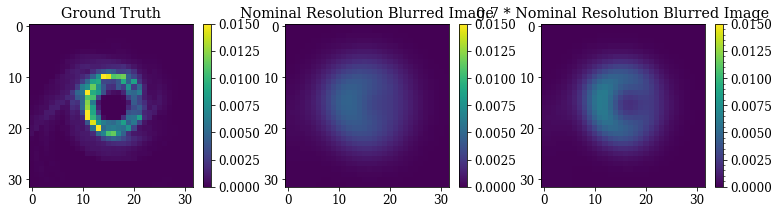

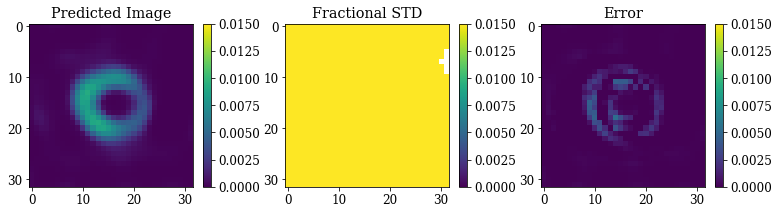

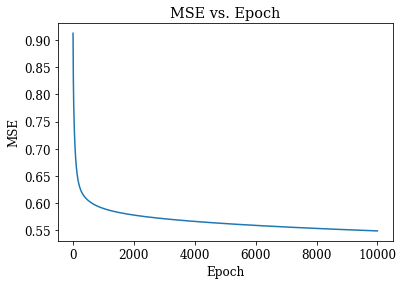

Prediction Chi^2:  0.2029659770412312
Prediction MAE:  0.0005033485211950193
Vis Chi^2 =  0.203
Cphase Chi^2 =  0.0654
Camp Chi^2 =  0.1426
MAE =  0.0005033485211950193
SSIM =  <function structural_similarity at 0x1377e9440>


In [18]:
run_rml(target, F_matrices, sigmas)